In [18]:
from __future__ import print_function
import numpy as np
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Input, Dense , Activation , Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D


In [19]:
import time
from PIL import Image
from keras import backend
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [20]:
height=128
width =128

content_image=Image.open('images/hugo.jpg')
content_image=content_image.resize((height,width))
#content_image

In [21]:
style_image=Image.open('images/styles/wave.jpg')
style_image=style_image.resize((height,width))
#style_image 

In [22]:
content_array = np.asarray(content_image, dtype='float32')
print(content_array.shape)
content_array=np.expand_dims(content_array,axis=0)
print (content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
print(style_array.shape)
style_array=np.expand_dims(style_array,axis=0)
print (style_array.shape)


(128, 128, 3)
(1, 128, 128, 3)
(128, 128, 3)
(1, 128, 128, 3)


In [23]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [24]:
content_input = backend.variable(content_array)
style_input  =backend.variable(style_array)
combination_output =backend.placeholder((1,height,width,3))

In [25]:
input_tensor = backend.concatenate([content_input,
                                    style_input,
                                    combination_output], axis=0)

In [26]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',include_top=False)

In [27]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 64, 64, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 32, 32, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 16, 16, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 16, 16, 512) dtype=float

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [29]:
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

In [30]:
loss = backend.variable(0.)

In [31]:
def content_loss(content , combination):
    return backend.sum(backend.square(combination-content))

feature_layer=layers['block2_conv2']

content_feature=feature_layer[0,:,:,:]
combination_feature=feature_layer[2,:,:,:]

loss= content_weight* content_loss(content_feature,combination_feature)

In [32]:
def gram_matrix(x):
    x=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    x=backend.dot(x,backend.transpose(x))
    return x

In [33]:
def style_loss(style, combination):
    style_gram=gram_matrix(style)
    combination_gram=gram_matrix(combination)
    channels=3
    size=height*width
    return backend.sum(backend.square(style_gram-combination_gram)) /  (4. * (channels ** 2) * (size ** 2))
                       
feature_layer =['block1_conv1','block2_conv2','block3_conv2','block4_conv3','block5_conv3']

for layer_name in feature_layer:
    f_layers=layers[layer_name]
    style_feature=f_layers[1,:,:,:]
    combination_feature=f_layers[2,:,:,:]
    loss+= style_weight/len(feature_layer)*style_loss(style_feature,combination_feature)
                

In [34]:
def total_variation_loss(x):
    row_variation= backend.square(x[:,1: , :width-1, :]-x[:, : height-1  , : width-1, :])
    column_variation= backend.square(x[:, :height-1 , 1: , :]-x[:,  :height-1 , : width-1 ,:])
    
    return backend.sum(backend.pow(row_variation + column_variation, 1.25))

loss += total_variation_weight  * total_variation_loss(combination_output)
    

In [35]:
grad=backend.gradients(loss,combination_output)
outputs = [loss]
outputs += grad
f_outputs=backend.function([combination_output],outputs)

In [36]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [37]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [38]:
evaluator=Evaluator()

In [39]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

for i in range (30):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    

Start of iteration 0
Current loss value: 3.41258e+10
Iteration 0 completed in 3s
Start of iteration 1
Current loss value: 2.00038e+10
Iteration 1 completed in 1s
Start of iteration 2
Current loss value: 1.48071e+10
Iteration 2 completed in 1s
Start of iteration 3
Current loss value: 1.26091e+10
Iteration 3 completed in 1s
Start of iteration 4
Current loss value: 1.14484e+10
Iteration 4 completed in 1s
Start of iteration 5
Current loss value: 1.06874e+10
Iteration 5 completed in 1s
Start of iteration 6
Current loss value: 1.00894e+10
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 9.69807e+09
Iteration 7 completed in 1s
Start of iteration 8
Current loss value: 9.33735e+09
Iteration 8 completed in 1s
Start of iteration 9
Current loss value: 9.08965e+09
Iteration 9 completed in 1s
Start of iteration 10
Current loss value: 8.8523e+09
Iteration 10 completed in 1s
Start of iteration 11
Current loss value: 8.6662e+09
Iteration 11 completed in 1s
Start of iteration 12
Curr

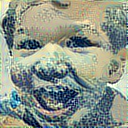

In [40]:
y=x
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)

In [41]:
for i in range (1):
    print('Start of iteration', i)
    start_time = time.time()
    y, min_val, info = fmin_l_bfgs_b(evaluator.loss, y.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    

Start of iteration 0
Current loss value: 3.15051e+10
Iteration 0 completed in 1s


In [42]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)

TypeError: Cannot cast ufunc add output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'